# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 1, #number of variables
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0.1,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': 3, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': 1, #default to 2 options:(None, 0,1 2)
        'nas': True,
        'nas_type': 'CNN-LSTM', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': True,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output


In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_21_drop0.25e500b256_custom/lnets_10000_30-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_5_sparsity_6_amin_-1_amax_1_xdist_uniform_noise_normal_0.1
lnets_10000_30-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_5_sparsity_6_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 out of   1 | elapsed:   31.0s finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
6252,1373158606,0.924,0.492,-0.142,-0.402,-0.741,0.255,0.941,0.421,-1.533,6.634,-11.500,5.498,0.911,0.605,-0.683,0.915,-2.125,0.759,-0.009,-0.227,0.414,0.340,0.169,0.103,0.419,-0.297,0.334,0.062,0.544,-0.088,-0.019,0.451,0.090,0.523,-0.042,0.202,0.265,0.229,-0.054,0.043,0.008,-0.042,-0.404,-0.090,0.333,-0.291,-0.209,-0.233,0.000,0.000,-0.212,-0.233,0.234,0.234,-0.286,0.000,-0.234,0.296,-0.243,0.000,0.000,-0.255,0.244,-0.205,0.232,0.254,0.227,0.242,0.288,-0.046,-0.023,0.000,0.000,0.000,-0.233,0.000,0.000,0.000,-0.254,-0.359,-0.566,-0.690,0.341,0.400,-0.479,-0.408,-0.789,0.120,-0.376,-0.352,-0.364,-0.443,0.341,-0.452,0.687,0.215,0.348,0.244,0.337,-0.311,-0.044,-0.261,-0.383,-0.059,-0.969,0.144,-0.258,-0.315,0.202
4684,1373158606,-0.794,0.241,-0.127,-0.188,-0.535,-0.939,-0.768,1.420,-14.454,48.213,-63.525,27.058,-0.794,0.232,0.112,-0.997,0.376,-1.277,-0.009,-0.227,0.231,0.122,0.313,0.080,0.185,-0.297,0.089,0.253,0.358,-0.088,-0.019,0.234,0.078,0.342,0.008,1.474,0.405,0.393,0.033,0.035,-0.043,-0.042,-0.404,-0.090,0.048,-0.291,-0.209,-0.233,0.000,0.000,0.172,0.175,0.001,-0.081,0.178,0.000,0.175,0.190,0.173,0.000,0.000,0.175,-0.079,0.172,-0.023,-0.949,0.001,0.000,-0.040,0.176,0.200,0.000,0.000,0.000,0.175,0.000,0.000,0.000,-0.254,-0.359,-0.339,-0.360,0.278,0.187,-0.191,-0.408,-0.396,-0.074,-0.188,-0.352,-0.364,-0.199,0.121,-0.265,0.393,-2.337,0.330,0.208,0.049,-0.458,-0.229,-0.261,-0.383,-0.059,-0.479,0.144,-0.258,-0.315,-0.168
1731,1373158606,-0.739,0.951,0.737,0.786,0.773,0.083,-0.721,0.346,4.731,-9.701,12.714,-4.814,-0.744,0.972,0.672,0.758,0.980,-0.046,-0.009,-0.227,-0.173,0.082,0.724,0.671,0.528,-0.297,0.067,0.916,0.416,-0.088,-0.019,0.349,0.689,-0.003,0.528,0.849,0.892,0.883,0.649,0.039,0.007,-0.042,-0.404,-0.090,0.046,-0.291,-0.209,-0.233,0.000,0.000,0.437,-0.092,-0.412,-0.438,-0.438,0.000,-0.078,-0.404,0.001,0.000,0.000,0.001,-0.463,0.398,-0.438,-0.280,-0.000,-0.140,-0.525,-0.054,-0.024,0.000,0.000,0.000,-0.060,0.000,0.000,0.000,-0.254,-0.359,-0.466,-0.215,0.917,1.043,0.791,-0.408,-0.251,0.617,0.148,-0.352,-0.364,0.190,1.010,-0.240,1.515,0.684,0.819,0.700,1.093,-0.306,-0.042,-0.261,-0.383,-0.059,-0.331,0.144,-0.258,-0.315,-0.437
4742,1373158606,0.173,-0.607,-0.085,0.746,-0.828,-0.939,0.161,-0.337,-2.491,8.142,-10.118,3.139,0.181,-0.787,0.885,-1.338,1.146,-1.629,-0.009,-0.227,0.511,0.469,0.050,-0.029,0.515,-0.297,0.433,0.595,0.678,-0.088,-0.019,0.540,-0.019,0.653,0.006,0.278,0.134,0.182,0.030,0.396,0.433,-0.042,-0.404,-0.090,0.397,-0.291,-0.209,-0.233,0.000,0.000,-0.264,-0.331,0.090,0.099,-0.363,0.000,-0.339,-0.404,-0.007,0.000,0.000,-0.279,0.089,-0.006,-0.025,-0.002,0.094,0.015,-0.044,-0.335,-0.366,0.000,0.000,0.000,-0.337,0.000,0.000,0.000,-0.254,-0.359,-0.691,-0.997,0.091,0.166,-0.746,-0.408,-1.085,-0.558,-0.418,-0.352,-0.364,-0.580,0.091,-0.495,0.391,-0.077,0.106,-0.017,0.043,-1.272,-1.217,-0.261,-0.383,-0.059,-1.255,0.144,-0.258,-0.315,0.121
4521,1373158606,0.131,0.208,0.871,0.323,0.573,0.164,0.124,0.308,0.697,-0.264,2.311,-0.934,0.132,0.241,0.293,2.685,-2.779,1.703,-0.009,-0.227,0.128,0.083,0.634,0.562,0.108,-0.297,0.067,0.951,0.400,-0.088,-0.019,0.126,0.521,0.243,0.398,0.706,0.723,0.705,0.612,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,1373158606.000,0.001,-0.005,-0.000,0.004,-0.003,-0.003,0.004,-0.025,0.136,-0.544,0.793,-0.364,0.001,-0.006,0.003,0.001,-0.003,-0.001,-0.009,-0.227,0.287,0.192,0.282,0.221,0.275,-0.297,0.162,0.454,0.475,-0.088,-0.019,0.322,0.222,0.404,0.079,0.415,0.370,0.393,0.149,0.112,0.058,-0.042,-0.404,-0.090,0.123,-0.291,-0.209,-0.233,0.000,0.000,-0.015,-0.027,-0.009,-0.015,-0.051,0.000,-0.026,-0.082,-0.046,0.000,0.000,-0.045,-0.023,-0.004,0.013,-0.066,0.018,-0.031,-0.016,-0.016,0.004,0.000,0.000,0.000,-0.018,0.000,0.000,0.000,-0.254,-0.359,-0.372,-0.424,0.354,0.419,-0.210,-0.408,-0.465,0.040,-0.106,-0.352,-0.364,-0.189,0.364,-0.265,0.627,0.118,0.358,0.176,0.332,-0.521,-0.258,-0.261,-0.383,-0.059,-0.544,0.144,-0.258,-0.315,0.004
std,0.000,0.574,0.577,0.577,0.577,0.575,0.580,0.542,0.650,3.538,10.664,13.939,5.786,0.574,0.621,1.539,3.677,4.051,1.706,0.000,0.000,0.142,0.143,0.158,0.156,0.171,0.000,0.142,0.277,0.201,0.000,0.000,0.168,0.163,0.145,0.148,0.243,0.162,0.187,0.202,0.140,0.182,0.000,0.000,0.000,0.139,0.000,0.000,0.000,0.000,0.000,0.147,0.158,0.170,0.179,0.189,0.000,0.158,0.293,0.218,0.000,0.000,0.185,0.192,0.145,0.155,0.249,0.137,0.214,0.212,0.152,0.176,0.000,0.000,0.000,0.152,0.000,0.000,0.000,0.000,0.000,0.177,0.234,0.212,0.248,0.342,0.000,0.257,0.446,0.450,0.000,0.000,0.347,0.263,0.236,0.311,0.502,0.179,0.439,0.346,0.287,0.334,0.000,0.000,0.000,0.278,0.000,0.000,0.000,0.139
min,1373158606.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.038,-2.548,-19.920,-73.162,-89.155,-43.752,-1.024,-1.581,-5.513,-14.253,-18.883,-6.767,-0.009,-0.227,-0.173,-0.289,-0.227,-0.278,-0.181,-0.297,-0.291,-0.132,0.099,-0.088,-0.019,-0.129,-0.290,-0.017,-0.301,-0.172,-0.094,-0.137,-0.640,-0.303,-0.633,-0.042,-0.404,-0.090,-0.291,-0.291,-0.209,-0.233,0.000,0.000,-0.469,-0.494,-0.560,-0.601,-0.958,0.000,-0.495,-1.158,-1.224,0.000,0.000,-1.010,-0.619,-0.962,-0.551,-1.123,-0.557,-1.056,-0.804,-0.496,-0.812,0.000,0.000,0.000,-0.496,0.000,0.000,0.000,-0.254,-0.359,-1.750,-1.862,-0.030,0.066,-1.360,-0.408,-2.213,-2.456,-0.918,-0.352,-0.364,-1.083,0.002,-0.982,0.260,-2.767,-1.802,-3.101,-0.695,-2.082,-3.002,-0.2

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.04991591],
       [0.55931928],
       [0.41215429],
       [0.47204459],
       [0.50702493],
       [0.36030918],
       [0.48300684],
       [0.91632547],
       [0.27265516],
       [0.88145597]])

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[1.0879322 ],
       [0.92128287],
       [0.94887895],
       [1.06356541],
       [1.04696906],
       [0.91303792],
       [0.84312583],
       [0.62768837],
       [1.02064446],
       [0.61265825]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 110)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 110)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 110)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
3003,1373158606,-0.340,-0.876,-0.048,-0.460,0.430,0.914,-0.318,-1.219,2.333,-7.451,9.054,-2.808,-0.320,-1.222,1.912,-5.138,5.331,-0.961,-0.009,-0.227,0.365,0.259,0.453,0.402,0.318,-0.297,0.226,0.374,0.488,-0.088,-0.019,0.366,0.424,0.474,0.009,0.532,0.531,0.522,0.506,0.174,0.102,-0.042,-0.404,-0.090,0.186,-0.291,-0.209,-0.233,0.000,0.000,0.075,0.076,-0.309,-0.326,0.076,0.000,0.076,0.083,0.075,0.000,0.000,0.076,-0.357,0.075,-0.023,-0.380,-0.265,-0.338,-0.425,0.076,0.085,0.000,0.000,0.000,0.076,0.000,0.000,0.000,-0.254,-0.359,-0.374,-0.366,0.847,1.064,-0.212,-0.408,-0.389,-0.101,-0.241,-0.352,-0.364,-0.231,1.094,-0.318,0.394,0.733,0.753,0.697,1.517,-0.428,-0.152,-0.261,-0.383,-0.059,-0.456,0.144,-0.258,-0.315,-0.075
5985,1373158606,-0.496,-0.607,0.252,0.645,-0.276,-0.135,-0.514,-0.250,-2.073,6.844,-7.191,2.565,-0.497,-0.595,0.264,0.351,0.331,-0.480,-0.009,-0.227,0.251,0.142,0.285,0.225,0.201,-0.297,0.109,0.250,0.375,-0.088,-0.019,0.251,0.224,0.361,0.008,0.341,0.366,0.350,0.198,0.055,-0.050,-0.042,-0.404,-0.090,0.068,-0.291,-0.209,-0.233,0.000,0.000,0.126,0.128,-0.103,-0.101,0.132,0.000,0.128,0.151,0.128,0.000,0.000,0.130,-0.109,0.126,-0.023,-0.121,-0.107,-0.117,-0.111,0.130,0.169,0.000,0.000,0.000,0.129,0.000,0.000,0.000,-0.254,-0.359,-0.316,-0.332,0.310,0.358,-0.165,-0.408,-0.366,-0.052,-0.171,-0.352,-0.364,-0.175,0.296,-0.248,0.393,0.186,0.336,0.222,0.298,-0.431,-0.231,-0.261,-0.383,-0.059,-0.451,0.144,-0.258,-0.315,-0.122
6925,1373158606,-0.316,0.287,0.323,-0.293,-0.713,0.105,-0.199,-0.106,0.000,-0.000,0.000,-0.000,-0.313,0.124,2.105,-6.294,7.160,-3.428,-0.009,-0.227,0.268,0.162,0.255,0.193,0.223,-0.297,0.129,0.282,0.391,-0.088,-0.019,0.270,0.189,0.376,0.012,0.303,0.341,0.319,0.097,0.077,0.009,-0.042,-0.404,-0.090,0.089,-0.291,-0.209,-0.233,0.000,0.000,0.058,0.059,0.001,0.001,0.058,0.000,0.059,0.052,0.058,0.000,0.000,0.058,0.001,0.058,-0.018,0.001,0.001,0.001,0.002,0.059,0.065,0.000,0.000,0.000,0.059,0.000,0.000,0.000,-0.254,-0.359,-0.289,-0.286,0.237,0.266,-0.130,-0.408,-0.312,-0.017,-0.153,-0.352,-0.364,-0.147,0.200,-0.230,0.395,0.120,0.277,0.159,0.098,-0.358,-0.105,-0.261,-0.383,-0.059,-0.383,0.144,-0.258,-0.315,-0.059
9619,1373158606,0.123,-0.670,0.322,-0.940,0.676,0.843,0.126,-1.059,4.630,-15.522,19.791,-7.659,0.126,-0.745,1.045,-3.259,3.478,-0.291,-0.009,-0.227,0.328,0.222,0.356,0.392,0.282,-0.297,0.189,0.333,0.450,-0.088,-0.019,0.329,0.423,0.436,0.456,0.234,0.275,0.252,0.564,0.137,0.062,-0.042,-0.404,-0.090,0.149,-0.291,-0.209,-0.233,0.000,0.000,-0.004,-0.007,-0.190,-0.316,-0.010,0.000,-0.006,-0.013,-0.015,0.000,0.000,-0.012,-0.339,-0.014,-0.338,0.054,0.066,0.060,-0.351,-0.005,-0.002,0.000,0.000,0.000,-0.005,0.000,0.000,0.000,-0.254,-0.359,-0.333,-0.321,0.535,1.018,-0.170,-0.408,-0.341,-0.060,-0.203,-0.352,-0.364,-0.191,1.024,-0.279,1.886,0.067,0.225,0.107,1.356,-0.371,-0.052,-0.261,-0.383,-0.059,-0.402,0.144,-0.258,-0.315,0.073
6916,1373158606,-0.533,-0.333,0.694,-0.708,0.255,-0.974,-0.413,-0.670,0.032,-0.073,0.074,-0.027,-0.530,-0.250,-0.109,1.185,-1.437,-0.456,-0.009,-0.227,0.336,0.230,0.198,0.133,0.291,-0.297,0.197,0.355,0.459,-0.088,-0.019,0.338,0.129,0.444,0.008,0.244,0.282,0.260,0.034,0.144,0.082,-0.042,-0.404,-0.090,0.156,-0.291,-0.209,-0.233,0.000,0.

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
8323,1373158606,0.310,0.452,0.977,-0.064,-0.261,0.704,0.268,0.991,0.838,-6.198,11.956,-5.805,0.325,0.208,2.430,-3.660,3.634,-0.813,-0.009,-0.227,0.130,0.082,0.396,0.332,0.109,-0.297,0.067,1.235,0.735,-0.088,-0.019,0.128,0.335,0.165,0.183,0.465,0.479,0.472,0.265,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.130,-0.083,0.069,0.071,-0.109,0.000,-0.069,-0.679,-0.581,0.000,0.000,-0.128,0.067,-0.165,0.076,0.060,0.071,0.064,0.058,-0.047,-0.023,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.198,-0.225,0.356,0.385,-0.040,-0.408,-0.258,1.138,1.249,-0.352,-0.364,-0.032,0.319,-0.049,0.551,0.238,0.396,0.278,0.220,-0.310,-0.045,-0.261,-0.383,-0.059,-0.334,0.144,-0.258,-0.315,0.083
5392,1373158606,0.502,-0.666,-0.803,0.182,0.483,-0.702,0.496,-0.260,-3.834,8.733,-9.909,3.801,0.515,-0.926,0.837,-3.808,4.577,-2.197,-0.009,-0.227,0.484,0.346,0.059,-0.012,0.442,-0.297,0.309,0.528,0.625,-0.088,-0.019,0.486,-0.017,0.603,-0.171,0.148,0.151,0.144,-0.158,0.281,0.271,-0.042,-0.404,-0.090,0.286,-0.291,-0.209,-0.233,0.000,0.000,-0.030,-0.198,0.162,0.171,-0.149,0.000,-0.218,-0.171,-0.002,0.000,0.000,-0.088,0.170,-0.001,0.188,0.108,0.159,0.139,0.210,-0.199,-0.205,0.000,0.000,0.000,-0.203,0.000,0.000,0.000,-0.254,-0.359,-0.495,-0.566,0.183,0.269,-0.373,-0.408,-0.632,-0.250,-0.363,-0.352,-0.364,-0.353,0.205,-0.440,0.671,0.016,0.180,0.061,0.264,-0.731,-0.549,-0.261,-0.383,-0.059,-0.743,0.144,-0.258,-0.315,0.173
4718,1373158606,0.390,0.568,-0.964,0.190,0.177,-0.243,0.407,0.144,1.337,-4.380,3.622,-0.967,0.387,0.565,-1.096,0.946,-0.985,0.312,-0.009,-0.227,0.333,0.232,0.199,0.136,0.303,-0.297,0.198,0.311,0.453,-0.088,-0.019,0.344,0.129,0.434,-0.010,0.243,0.289,0.263,0.008,0.174,0.008,-0.042,-0.404,-0.090,0.177,-0.291,-0.209,-0.233,0.000,0.000,-0.126,-0.125,0.130,0.130,-0.137,0.000,-0.129,0.016,-0.140,0.000,0.000,-0.133,0.133,-0.135,0.132,0.136,0.128,0.132,0.155,-0.113,-0.022,0.000,0.000,0.000,-0.115,0.000,0.000,0.000,-0.254,-0.359,-0.399,-0.428,0.254,0.299,-0.253,-0.408,-0.473,-0.041,-0.244,-0.352,-0.364,-0.258,0.236,-0.322,0.562,0.130,0.279,0.166,0.200,-0.581,-0.045,-0.261,-0.383,-0.059,-0.588,0.144,-0.258,-0.315,0.122
990,1373158606,-0.178,-0.531,-0.961,0.759,0.931,-0.317,-0.157,-1.101,3.285,-11.782,16.440,-7.057,-0.182,-0.415,-1.312,0.689,1.816,-0.884,-0.009,-0.227,0.338,0.232,0.390,0.323,0.292,-0.297,0.199,0.350,0.461,-0.088,-0.019,0.340,0.337,0.447,0.010,0.443,0.435,0.432,0.367,0.147,0.077,-0.042,-0.404,-0.090,0.159,-0.291,-0.209,-0.233,0.000,0.000,0.042,0.042,-0.219,-0.241,0.041,0.000,0.042,0.039,0.041,0.000,0.000,0.041,-0.253,0.042,-0.022,-0.270,-0.231,-0.263,-0.276,0.042,0.044,0.000,0.000,0.000,0.042,0.000,0.000,0.000,-0.254,-0.359,-0.344,-0.334,0.595,0.712,-0.182,-0.408,-0.357,-0.071,-0.212,-0.352,-0.364,-0.202,0.667,-0.289,0.394,0.450,0.559,0.468,0.896,-0.393,-0.109,-0.261,-0.383,-0.059,-0.421,0.144,-0.258,-0.315,-0.042
6498,1373158606,0.861,-0.387,-0.550,0.460,0.491,-0.056,0.779,-0.195,-0.003,0.007,-0.007,0.003,0.869,-0.439,-0.396,-0.019,1.263,-0.460,-0.009,-0.227,0.328,0.237,0.221,0.157,0.301,-0.297,0.208,0.178,0.449,-0.088,-0.019,0.339,0.150,0.431,0.013,0.263,0.311,0.284,0.030,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
7217,1373158606,0.715,0.432,0.981,-0.843,-0.740,-0.831,0.712,0.906,-3.423,12.732,-17.553,6.388,0.718,0.388,1.013,-0.441,-1.667,-0.267,-0.009,-0.227,0.551,0.483,0.261,0.198,0.594,-0.297,0.456,0.193,0.669,-0.088,-0.019,0.588,0.188,0.624,0.057,0.299,0.353,0.322,0.066,0.478,0.008,-0.042,-0.404,-0.090,0.457,-0.291,-0.209,-0.233,0.000,0.000,-0.299,-0.368,0.185,0.185,-0.419,0.000,-0.398,0.207,-0.363,0.000,0.000,-0.408,0.191,-0.338,0.183,0.199,0.180,0.191,0.222,-0.388,-0.022,0.000,0.000,0.000,-0.386,0.000,0.000,0.000,-0.254,-0.359,-0.910,-1.276,0.346,0.391,-1.018,-0.408,-1.491,0.093,-0.683,-0.352,-0.364,-0.898,0.329,-0.754,0.625,0.223,0.369,0.257,0.278,-1.739,-0.045,-0.261,-0.383,-0.059,-1.706,0.144,-0.258,-0.315,0.164
8291,1373158606,-0.213,0.402,-0.761,-0.041,-0.451,-0.243,-0.180,-0.014,0.537,-0.987,-1.331,0.714,-0.217,0.535,-1.376,1.067,-1.325,0.011,-0.009,-0.227,0.286,0.453,0.253,0.189,0.516,-0.297,0.360,0.711,0.416,-0.088,-0.019,0.547,0.188,0.397,0.008,0.307,0.337,0.323,0.032,0.350,0.471,-0.042,-0.404,-0.090,0.354,-0.291,-0.209,-0.233,0.000,0.000,0.093,-0.168,-0.002,-0.002,-0.293,0.000,-0.286,-0.405,0.085,0.000,0.000,-0.205,-0.002,0.095,-0.023,-0.003,-0.002,-0.002,-0.037,-0.281,-0.373,0.000,0.000,0.000,-0.253,0.000,0.000,0.000,-0.254,-0.359,-0.323,-0.733,0.222,0.248,-0.644,-0.408,-0.880,-0.641,-0.180,-0.352,-0.364,-0.542,0.181,-0.261,0.393,0.103,0.263,0.144,0.047,-1.077,-1.181,-0.261,-0.383,-0.059,-1.001,0.144,-0.258,-0.315,-0.108
4607,1373158606,0.514,-0.410,-0.766,-0.485,-0.225,-0.896,0.504,-0.223,-2.133,3.540,-5.265,1.293,0.540,-1.066,3.452,-11.112,11.162,-5.249,-0.009,-0.227,0.663,0.560,-0.115,-0.166,0.640,-0.297,0.530,0.752,0.788,-0.088,-0.019,0.691,-0.167,0.791,-0.254,0.468,0.018,0.278,-0.281,0.481,0.535,-0.042,-0.404,-0.090,0.485,-0.291,-0.209,-0.233,0.000,0.000,-0.327,-0.412,0.115,0.166,-0.442,0.000,-0.424,-0.484,-0.294,0.000,0.000,-0.369,0.167,-0.166,0.253,0.137,0.117,0.149,0.280,-0.411,-0.428,0.000,0.000,0.000,-0.414,0.000,0.000,0.000,-0.254,-0.359,-0.857,-1.084,0.122,0.305,-0.857,-0.408,-1.183,-0.686,-0.608,-0.352,-0.364,-0.755,0.244,-0.657,0.805,-0.222,0.051,-0.113,0.405,-1.307,-1.185,-0.261,-0.383,-0.059,-1.311,0.144,-0.258,-0.315,0.132
5114,1373158606,-0.373,0.948,0.872,0.284,-0.963,0.497,-0.337,0.233,4.836,-8.996,8.775,-3.282,-0.362,0.882,1.143,-0.511,0.152,-0.040,-0.009,-0.227,0.137,0.087,0.503,0.430,0.117,-0.297,0.070,0.643,0.305,-0.088,-0.019,0.138,0.439,0.243,0.258,0.581,0.582,0.582,0.367,0.042,0.008,-0.042,-0.404,-0.090,0.048,-0.291,-0.209,-0.233,0.000,0.000,-0.138,-0.091,-0.011,-0.058,-0.117,0.000,-0.075,-0.182,-0.050,0.000,0.000,-0.136,-0.059,-0.050,-0.155,-0.044,-0.015,-0.038,-0.158,-0.051,-0.024,0.000,0.000,0.000,-0.057,0.000,0.000,0.000,-0.254,-0.359,-0.190,-0.225,0.474,0.509,-0.032,-0.408,-0.257,0.262,0.036,-0.352,-0.364,-0.006,0.445,-0.043,0.778,0.354,0.505,0.390,0.407,-0.309,-0.044,-0.261,-0.383,-0.059,-0.334,0.144,-0.258,-0.315,-0.328
1859,1373158606,0.664,-0.380,0.886,-0.641,0.325,0.344,0.522,0.397,-0.001,0.002,-0.002,0.001,0.652,-0.318,1.239,-2.754,3.568,-1.206,-0.009,-0.227,0.250,0.082,0.290,0.227,0.203,-0.297,0.067,0.285,0.367,-0.088,-0.019,0.250,0.223,0.354,0.086,0.338,0.377,0.355,0.127,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.

## Interpretation Network Training

In [23]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 
 
per_network_preds_list,

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

Trial 37 Complete [00h 15m 17s]
val_loss: 0.22374171018600464

Best val_loss So Far: 0.04912727326154709
Total elapsed time: 04h 14m 10s

Search: Running Trial #38

Hyperparameter    |Value             |Best Value So Far 
conv_block_1/ke...|5                 |5                 
conv_block_1/se...|False             |False             
conv_block_1/ma...|True              |True              
conv_block_1/dr...|0                 |0                 
conv_block_1/nu...|2                 |2                 
conv_block_1/nu...|2                 |2                 
conv_block_1/fi...|16                |32                
conv_block_1/fi...|512               |512               
conv_block_1/fi...|32                |32                
conv_block_1/fi...|32                |32                
rnn_block_1/bid...|True              |True              
rnn_block_1/lay...|lstm              |lstm              
rnn_block_1/num...|2                 |2                 
dense_block_1/u...|False             

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



32/32 [==============================] - 8s 253ms/step - loss: 0.1704 - val_loss: 0.1830
Epoch 84/500
32/32 [==============================] - 8s 257ms/step - loss: 0.1792 - val_loss: 0.1793
Epoch 85/500
32/32 [==============================] - 8s 257ms/step - loss: 0.1779 - val_loss: 0.1899
Epoch 86/500
32/32 [==============================] - 8s 253ms/step - loss: 0.1856 - val_loss: 0.1801
Epoch 87/500
32/32 [==============================] - 8s 257ms/step - loss: 0.1798 - val_loss: 0.1737
Epoch 88/500
32/32 [==============================] - 8s 246ms/step - loss: 0.1739 - val_loss: 0.1750
Epoch 89/500
32/32 [==============================] - 8s 252ms/step - loss: 0.1742 - val_loss: 0.1705
Epoch 90/500
32/32 [==============================] - 8s 254ms/step - loss: 0.1740 - val_loss: 0.1641
Epoch 91/500
32/32 [==============================] - 8s 249ms/step - loss: 0.1692 - val_loss: 0.1770
Epoch 92/500
32/32 [==============================] - 8s 255ms/step - loss: 0.1718 - val_loss: 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



32/32 [==============================] - 10s 301ms/step - loss: 0.1630 - val_loss: 0.1649
Epoch 382/500
32/32 [==============================] - 10s 326ms/step - loss: 0.1693 - val_loss: 0.1663
Epoch 383/500
32/32 [==============================] - 9s 292ms/step - loss: 0.1750 - val_loss: 0.1643
Epoch 384/500
32/32 [==============================] - 10s 300ms/step - loss: 0.1678 - val_loss: 0.1781
Epoch 385/500
32/32 [==============================] - 10s 305ms/step - loss: 0.1871 - val_loss: 0.1744
Epoch 386/500
32/32 [==============================] - 9s 290ms/step - loss: 0.1761 - val_loss: 0.1639
Epoch 387/500
32/32 [==============================] - 9s 296ms/step - loss: 0.1737 - val_loss: 0.1636
Epoch 388/500
32/32 [==============================] - 10s 298ms/step - loss: 0.1692 - val_loss: 0.1621
Epoch 389/500
32/32 [==============================] - 9s 280ms/step - loss: 0.1649 - val_loss: 0.1655
Epoch 390/500
32/32 [==============================] - 9s 275ms/step - loss: 0.167

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Evaluate Interpretation Net

In [26]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

Trial summary
Hyperparameters:
conv_block_1/kernel_size: 5
conv_block_1/separable: False
conv_block_1/max_pooling: True
conv_block_1/dropout: 0
conv_block_1/num_blocks: 2
conv_block_1/num_layers: 2
conv_block_1/filters_0_0: 32
conv_block_1/filters_0_1: 512
conv_block_1/filters_1_0: 32
conv_block_1/filters_1_1: 32
rnn_block_1/bidirectional: True
rnn_block_1/layer_type: lstm
rnn_block_1/num_layers: 2
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 2
dense_block_1/units_0: 32
dense_block_1/dropout: 0.0
dense_block_1/units_1: 32
optimizer: adam
learning_rate: 0.001
Score: 0.04912727326154709
None
Trial summary
Hyperparameters:
conv_block_1/kernel_size: 3
conv_block_1/separable: False
conv_block_1/max_pooling: True
conv_block_1/dropout: 0
conv_block_1/num_blocks: 2
conv_block_1/num_layers: 2
conv_block_1/filters_0_0: 32
conv_block_1/filters_0_1: 512
conv_block_1/filters_1_0: 32
conv_block_1/filters_1_1: 32
rnn_block_1/bidirectional: True
rnn_block_1/layer_type: lstm
rnn_block_1

In [27]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 30, 4)        0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 26, 32)       672         cast_to_float32[0][0]            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 22, 512)      82432       conv1d[0][0]                     
______________________________________________________________________________________________

In [28]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [29]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,1.526,2.342,14.294,0.070,0.000,0.170,0.213,26.307,-4.893,0.695,1.261,0.162,0.046,0.009,0.703,0.785
inetPoly_VS_targetPoly_test,1.520,2.318,3.606,0.069,0.000,0.172,0.214,24.057,-1.743,0.680,1.279,0.163,-0.006,-0.053,0.695,0.773
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.163,0.203,25.311,-0.027,0.577,1.061,0.152,0.046,0.010,0.703,0.781
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.164,0.205,23.114,-0.058,0.573,1.081,0.153,-0.006,-0.053,0.695,0.769
inetPoly_VS_lstsqTarget_valid,2.576,3.583,13.869,0.059,0.000,0.170,0.213,26.335,-4.889,0.694,1.251,0.162,0.046,0.009,0.703,0.785
inetPoly_VS_lstsqTarget_test,2.559,3.626,12.047,0.060,0.000,0.172,0.214,24.065,-1.774,0.681,1.285,0.163,-0.006,-0.053,0.695,0.773
inetPoly_VS_lstsqLambda_valid,5.668,10.029,28.165,0.073,0.001,0.163,0.203,25.311,-0.025,0.576,1.056,0.152,0.046,0.010,0.703,0.781
inetPoly_VS_lstsqLambda_test,5.323,9.270,38.581,0.078,0.000,0.164,0.204,23.114,-0.057,0.573,1.082,0.153,-0.006,-0.053,0.695,0.769
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.004,0.006,0.065,0.999,0.018,0.067,0.006,0.010,0.010,0.781,0.781
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.004,0.005,0.040,0.999,0.016,0.064,0.005,-0.053,-0.053,0.769,0.769


In [30]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.231,0.040,0.254,0.118,0.055,0.220,0.417,0.048,0.191,0.399,0.071,0.343,0.412,0.268,0.424,0.250,0.249,0.043,0.054,0.290,0.189,0.298,0.225,0.165,0.081,0.111,0.380,0.237,0.316,0.108,0.021,0.021,0.136,0.292,0.130,0.274,0.032,0.036,0.097,0.080,0.022,0.196,0.082,0.016,0.056,0.260,0.029,0.065,0.053,0.058,0.227,0.164,0.438,0.370,0.037,0.125,0.029,0.315,0.351,0.126,0.393,0.074,0.042,0.086,0.095,0.024,0.245,0.437,0.045,0.643,0.025,0.413,0.385,0.024,0.341,0.021,0.037,0.012,0.223,0.044,0.042,0.059,0.360,0.026,0.195,0.020,0.071,0.082,0.268,0.305,0.014,0.206,0.034,0.032,0.279,0.346,0.221,0.173,0.067,0.023,0.046,0.122,0.032,0.116,0.033,0.045,0.027,0.018,0.033,0.254,0.176,0.025,0.148,0.566,0.289,0.347,0.117,0.148,0.365,0.409,0.018,0.024,0.034,0.385,0.387,0.036,0.159,0.457,0.051,0.033,0.040,0.057,0.041,0.393,0.034,0.039,0.180,0.035,0.035,0.193,0.034,0.370,0.139,0.342,0.093,0.032,0.279,0.045,0.342,0.097,0.101,0.144,0.566,0.049,0.139,0.058,0.341,0.045,0.040,0.539,0.018,0.419,0.082,0.049,0.378,0.237,0.471,0.088,0.123,0.116,0.431,0.316,0.228,0.141,0.059,0.033,0.284,0.027,0.074,0.

In [31]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.827,0.988,-21.037,0.584,-0.614,-1.622,-0.560,0.994,-0.753,-0.578,-3942.040,-1.463,0.599,-0.182,-1.521,0.677,-0.533,0.985,0.943,-0.741,0.775,-0.552,-1.264,0.687,0.113,-11.211,-0.680,0.245,-0.211,0.975,0.997,0.992,0.871,-4.659,-2.385,0.843,0.915,0.993,0.617,0.924,0.994,0.490,-6.222,0.981,-9.441,-0.343,0.990,0.992,0.979,0.810,0.794,0.532,-0.328,-0.447,0.990,0.652,0.895,-4.705,0.780,0.726,0.811,0.719,0.363,0.967,0.859,0.974,-0.681,-0.065,0.942,0.021,-1.078,0.111,-2.005,0.943,0.316,0.995,0.978,0.999,0.749,0.984,0.957,0.977,-0.181,0.990,0.868,0.998,0.358,0.984,0.418,0.060,0.994,-5.890,-14.909,0.900,0.619,-0.578,-0.646,-0.043,-11.711,0.989,0.986,-0.118,0.638,-1.142,0.993,0.985,0.992,0.960,0.991,0.801,0.133,0.980,-0.113,0.654,-0.243,-1.133,0.595,0.616,-0.131,-0.216,0.999,0.995,0.677,-1.314,-1.654,0.991,-2.598,0.584,0.991,0.991,0.993,0.991,0.992,-0.002,0.983,0.995,0.880,0.853,0.913,0.385,0.923,0.253,0.590,-7.889,-5.209,-35.173,-0.843,-5.020,0.332,0.862,-103.844,0.942,-3.229,0.842,0.816,0.972,0.498,0.968,0.639,0.754,0.987,0.696,0.838,0.974,0.141,0.576,0.172,0.652,0.91

In [32]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-1.1903609513085551


-2.49855199456215*a**2.0 + 2.07238364219666*a**4.0

In [33]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-12964.854577020506


-0.0144180507096363*a**1.0 + 0.0607845608051884*a**2.0 - 0.137557339109865*a**3.0 + 0.138166555509527*a**4.0 - 0.0508871552762161*a**5.0 - 0.646764747333045

In [34]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.004393827627128*a**1.0 + 0.457417409203298*a**2.0 + 0.50202434551022*a**3.0 - 0.548171232247483*a**4.0 - 0.799800974305493*a**5.0 - 0.701293378218257

In [35]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.9940408052521161


-2.27345538139343*a**2.0 + 0.89297878742218*a**3.0 + 0.77249276638031

In [36]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9998232418462257


0.0515725748404566*a**1.0 - 2.31155843859545*a**2.0 + 2.44145924559806*a**3.0 - 3.13063218736376*a**4.0 + 1.60934559521781*a**5.0 + 0.752756024263297

In [37]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.308245078524285*a**1.0 - 0.691080505553352*a**2.0 - 0.949104480188498*a**3.0 + 0.291644772572969*a**4.0 + 0.273804634909486*a**5.0 + 0.780194070367617

In [38]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -1.7434042252957618 (1000 Samples)
Mean (only positive): 0.7661399259472796 (695 Samples)


In [39]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: -16.71293076867653 (1000 Samples)
Mean (only positive): 0.9541026786486356 (904 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

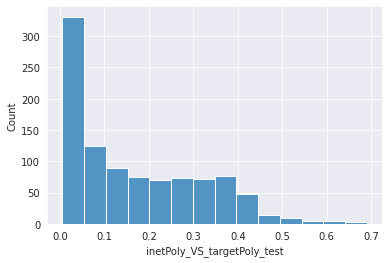

In [40]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

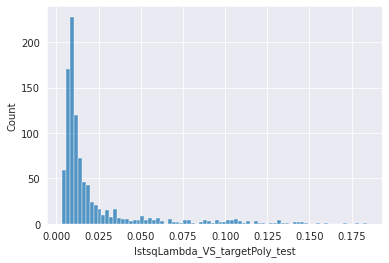

In [41]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50])


[(-30.0, 1.0)]

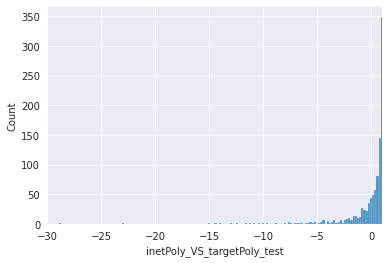

In [42]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

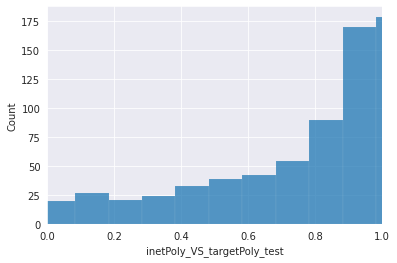

In [43]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

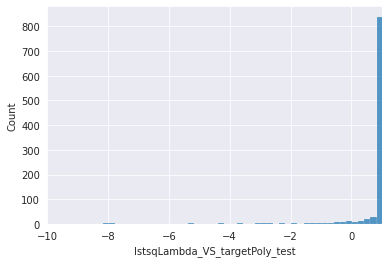

In [44]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

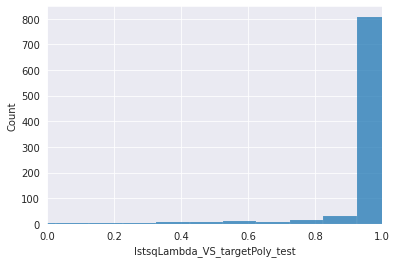

In [45]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

In [46]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [47]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [48]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [49]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [50]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [51]:
index = 6

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]
per_network_poly = per_network_preds_list[-1][index]

print('Target Poly:')
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Target Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Lambda Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_lambda, force_complete_poly_representation=True, round_digits=4)
print('I-Net Poly:')
print_polynomial_from_coefficients(polynomial_inet, round_digits=4)
print('Per Network Optimization Poly:')
print_polynomial_from_coefficients(per_network_poly, round_digits=4)



Target Poly:


0.8804*a**1.0 - 0.7895*a**2.0 - 0.3549*a**3.0 + 0.3058*a**4.0 + 0.9988*a**5.0 - 0.3765

LSTSQ Target Poly:


0.9886*a**1.0 - 1.4002*a**2.0 + 1.4736*a**3.0 - 2.2087*a**4.0 + 2.213*a**5.0 - 0.3826

LSTSQ Lambda Poly:


-0.1089*a**1.0 + 4.2759*a**2.0 - 11.677*a**3.0 + 12.2308*a**4.0 - 3.8129*a**5.0 - 0.3189

I-Net Poly:


-0.607799977064133*a**2.0 + 1.20809996128082*a**4.0

Per Network Optimization Poly:


0.792100012302399*a**3.0 - 0.252099998295307

In [52]:
lambda_net_test_dataset_list[0].X_test_data_list[0][:10]

array([[0.52705768],
       [0.0322892 ],
       [0.40475921],
       [0.14230531],
       [0.13426314],
       [0.90257457],
       [0.4960394 ],
       [0.63989715],
       [0.81111041],
       [0.02596585]])

In [53]:
lambda_net_test_dataset_list[0].y_test_data_list[0][:10]

array([[0.93729651],
       [0.51808388],
       [1.04651217],
       [0.95772168],
       [0.91528308],
       [0.33733302],
       [1.0665945 ],
       [1.01929303],
       [0.66982232],
       [0.7507296 ]])

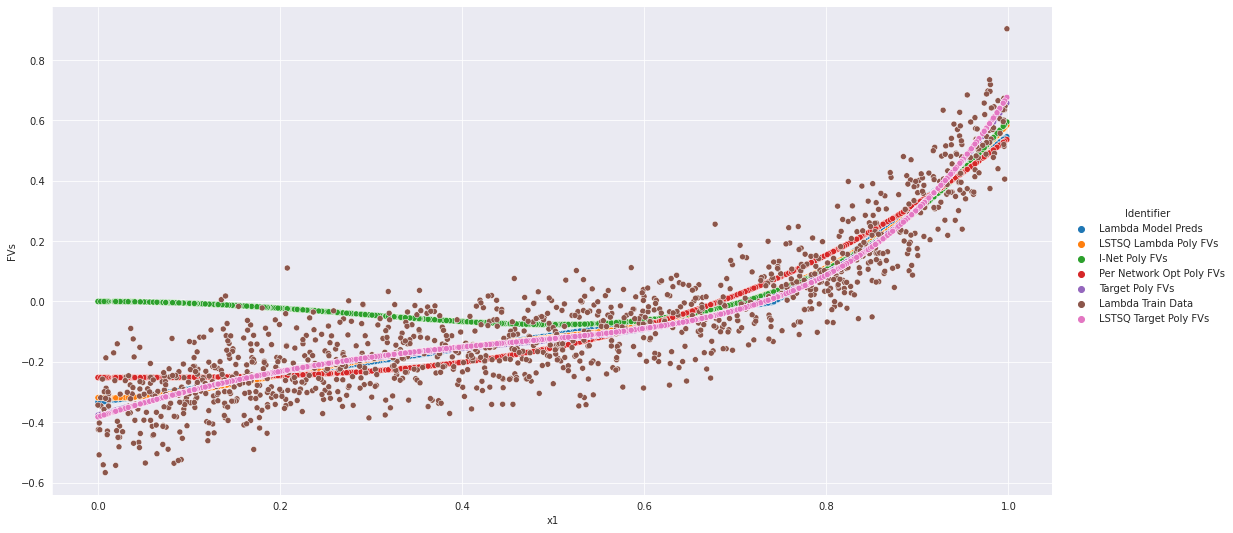

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.008978770164034365 | 0.9974205321664991 |   -    |  -0.1089*a**1.0 + 4.2759*a**2.0 - 11.677*a**3.0 +  |
|            vs.            |                      |                    |        |      12.2308*a**4.0 - 3.8129*a**5.0 - 0.3189       |
|  LSTSQ Lambda Preds Poly  |                      |                    |        |                                                    |
|                           |                      |                    |        |                                                    |
|       Lambda Preds        | 0.1065219154151199

In [54]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      per_network_preds_list,
                                                      rand_index=index, 
                                                      plot_type=1)

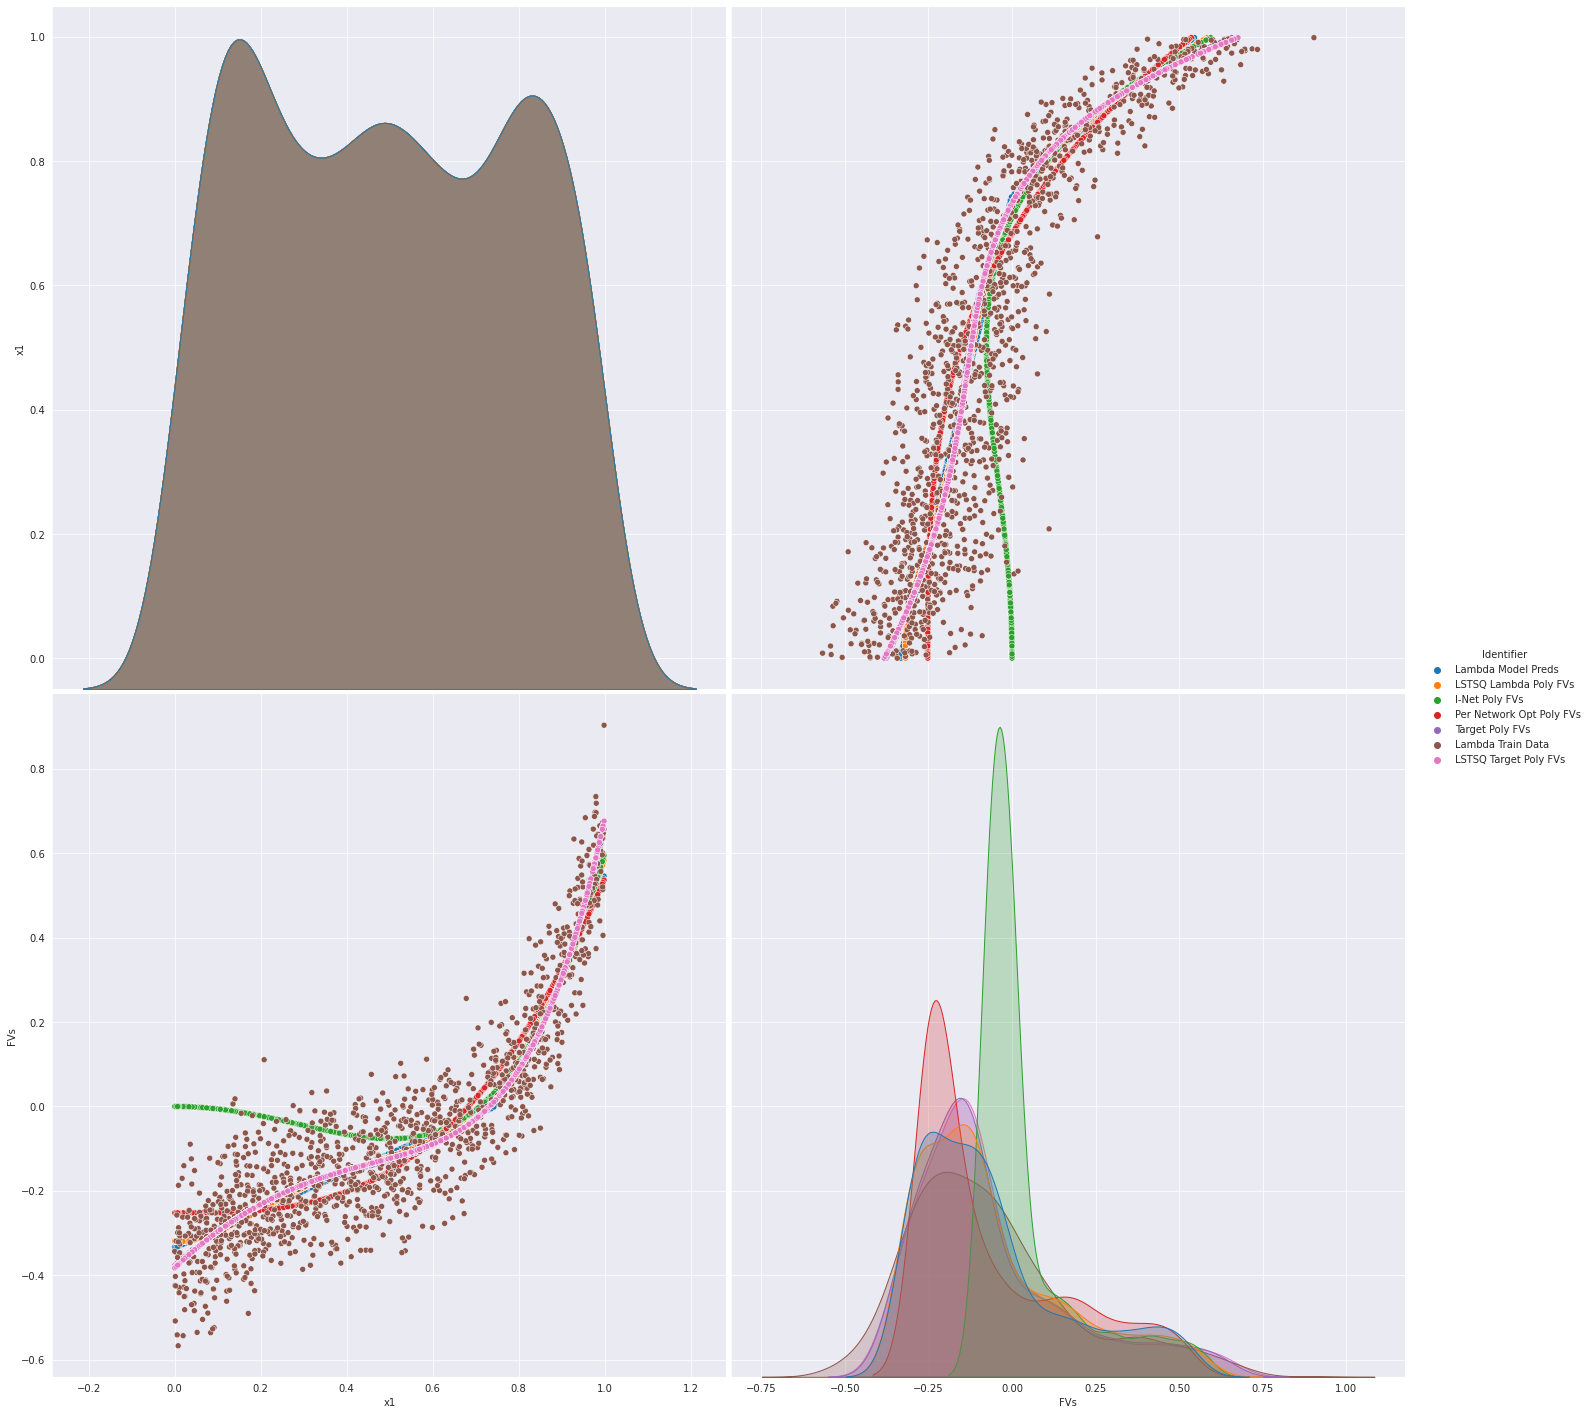

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.008978770164034365 | 0.9974205321664991 |   -    |  -0.1089*a**1.0 + 4.2759*a**2.0 - 11.677*a**3.0 +  |
|            vs.            |                      |                    |        |      12.2308*a**4.0 - 3.8129*a**5.0 - 0.3189       |
|  LSTSQ Lambda Preds Poly  |                      |                    |        |                                                    |
|                           |                      |                    |        |                                                    |
|       Lambda Preds        | 0.1065219154151199

In [55]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      per_network_preds_list,
                                                      rand_index=index, 
                                                      plot_type=2)

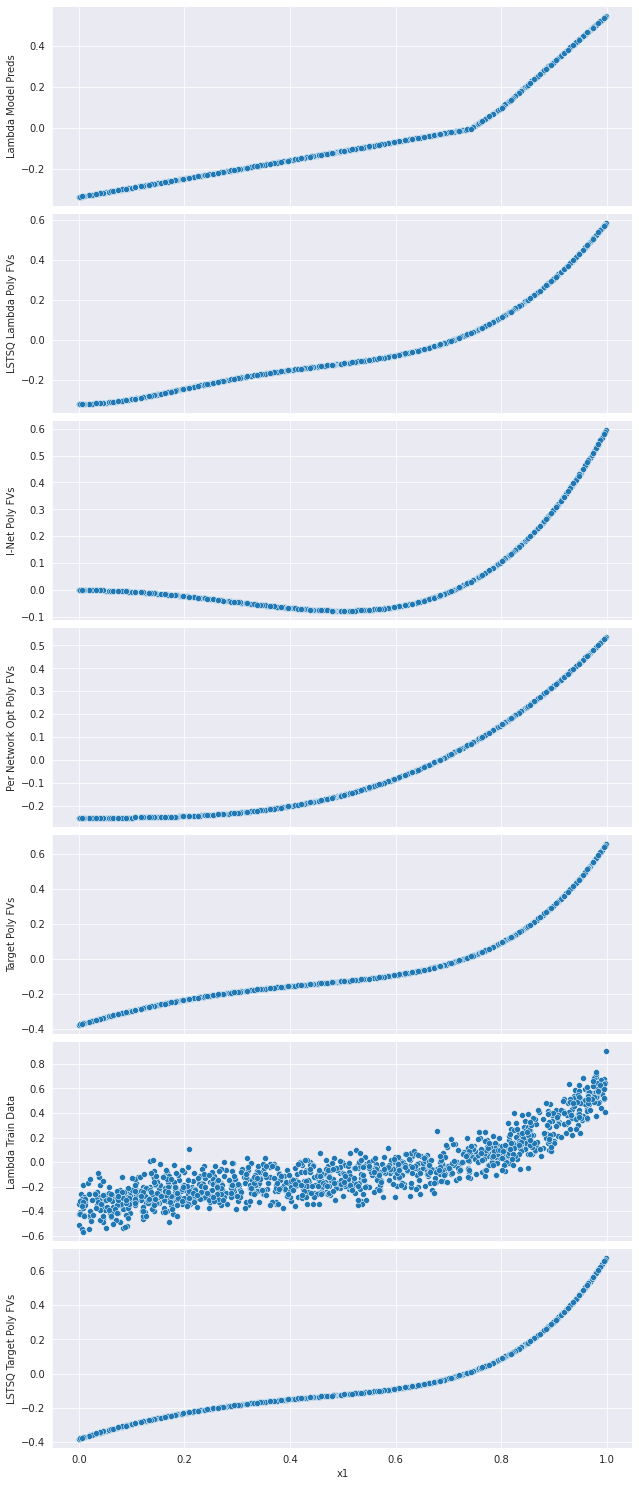

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.008978770164034365 | 0.9974205321664991 |   -    |  -0.1089*a**1.0 + 4.2759*a**2.0 - 11.677*a**3.0 +  |
|            vs.            |                      |                    |        |      12.2308*a**4.0 - 3.8129*a**5.0 - 0.3189       |
|  LSTSQ Lambda Preds Poly  |                      |                    |        |                                                    |
|                           |                      |                    |        |                                                    |
|       Lambda Preds        | 0.1065219154151199

In [56]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      per_network_preds_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [57]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [58]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [59]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.0368


In [60]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 6.3545


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [61]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [62]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.6149


In [63]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [64]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()

In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 